In [1]:
import sys
import os

# append the path of the parent directory
sys.path.append("../src")
sys.path.append("../src/simulator")

os.path.abspath(os.getcwd())

'/home/michel/Documents/BPO_Batching/notebooks'

In [2]:
import pm4py
import pandas as pd
import pickle
from simulator.simulator import Simulator
from planner import Planner
from policy import *
from pm4py.visualization.petri_net.common import visualize

2024-02-29 12:47:48.048652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 12:47:48.048678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 12:47:48.049595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 12:47:48.056034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 12:47:49.063620: W tensorflow/compiler/tf2

In [3]:
os.chdir('..')
os.path.abspath(os.getcwd())

'/home/michel/Documents/BPO_Batching'

In [4]:
with open('prediction_model.pkl', 'rb') as file:
        prediction_model = pickle.load(file)

In [5]:
class LoggingPlanner(Planner):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.completed_cases = []
        self.events = []

    def task_activate(self, event):
        self.events.append(event)

    def complete_case(self, event):
        super().complete_case(event)
        self.completed_cases.append(event.case_id)

In [26]:
my_policy = RandomPolicy()
my_planner = LoggingPlanner(prediction_model, RandomPolicy(), 0, my_policy,
                    predict_multiple=True,
                    hour_timeout=3600,
                    debug=True)

simulator = Simulator(my_planner)
simulator_result = simulator.run(1000)

2020-01-01 00:57:00.358593 0.8039586544036865 2 3
2020-01-01 01:57:34.086659 1.8484938144683838 1 3
2020-01-01 02:59:55.654734 1.7646358013153076 5 3
2020-01-01 03:57:38.641660 2.0671420097351074 23 3
2020-01-01 04:59:35.801802 2.281290292739868 28 3
2020-01-01 05:59:21.986811 2.6609175205230713 33 3
2020-01-01 06:59:04.642732 3.3666844367980957 32 3
2020-01-01 07:59:29.579738 1.2395553588867188 41 1
2020-01-01 08:52:31.903709 1.6937384605407715 47 1
2020-01-01 09:56:10.410867 1.4428505897521973 52 1
2020-01-01 10:57:03.460418 1.4701652526855469 65 1
2020-01-01 11:56:19.950470 1.9453117847442627 85 1
2020-01-01 12:56:33.263996 1.2545826435089111 84 1
2020-01-01 13:58:34.065124 1.5322628021240234 84 1
2020-01-01 14:57:54.244647 1.904451608657837 98 1
2020-01-01 15:54:41.321888 1.399825096130371 104 1
2020-01-01 16:52:52.545757 1.5739710330963135 103 1
2020-01-01 17:59:34.033331 1.425771951675415 103 1
2020-01-01 18:58:10.422948 1.99363112449646 119 1
2020-01-01 19:57:30.423519 2.2490098

In [27]:
selected_events = []
for event in my_planner.events:
    if event.task.case_id in my_planner.completed_cases:
        selected_events.append(event)

event_log = pd.DataFrame(columns=['concept:name', 'case:concept:name', 'time:timestamp'],
                          data=[(event.task.task_type, event.task.case_id, event.timestamp) for event in selected_events])


event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'], unit='s')
event_log['concept:name'] = event_log['concept:name'].astype(str)
event_log['case:concept:name'] = event_log['case:concept:name'].astype(str)


In [33]:
len(event_log)
first_500_cases = event_log[event_log['case:concept:name'].astype(int) < 500]

In [34]:
first_10k = event_log[:10000]
net = pm4py.discover_heuristics_net(first_500_cases, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

/home/michel/.local/share/virtualenvs/BPO_Batching-9ubDlYK6/lib/python3.10/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


In [ ]:
net

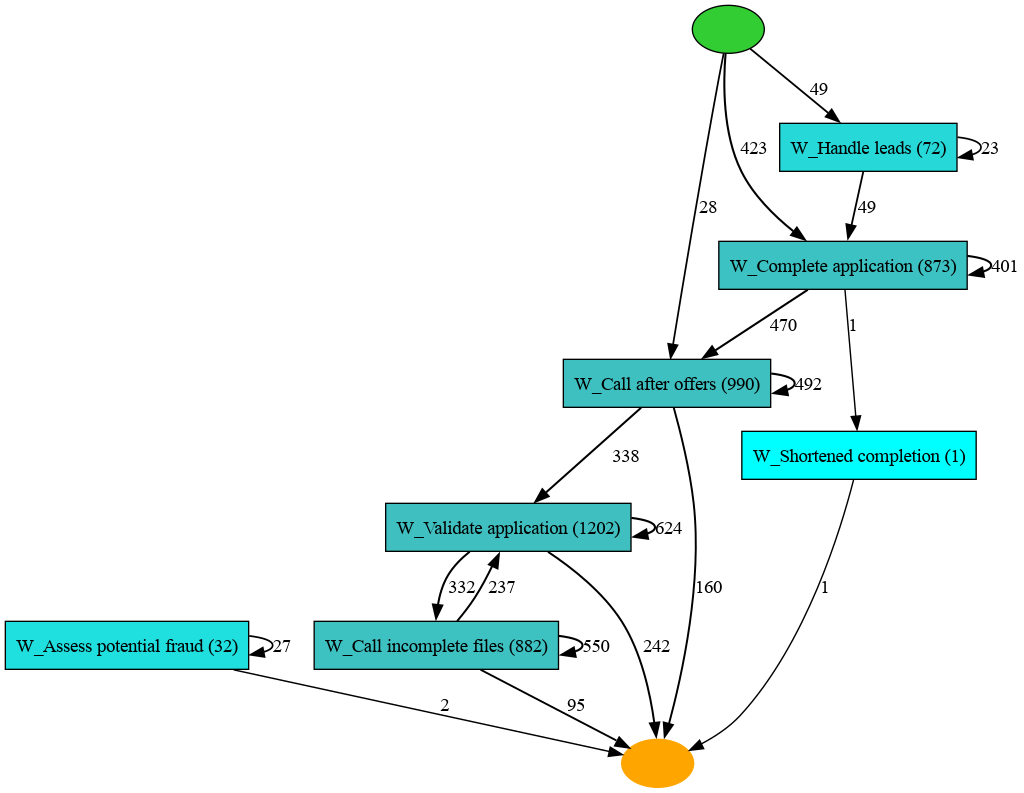

In [46]:
fig = pm4py.view_heuristics_net(net)

In [54]:
pm4py.save_vis_heuristics_net(net, 'net.png')

''